# Bibliotécas

In [238]:
# Manipulação de dados
import pandas as pd
import numpy as np
import inflection
from imblearn.over_sampling import SMOTE

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import shap

# Modelagem estatística
from scipy.stats import shapiro, anderson
from statsmodels.stats.diagnostic import lilliefors

# Machine Learning: Modelos e Avaliação
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection as ms
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix
from sklearn import metrics

# Pipelines para tratar dados futuros
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Exportar para pdf
import subprocess
import os

# Configurações Gerais
import warnings
import pickle
from IPython.display import HTML

# Configuração de exibição dos gráficos no Jupyter
%matplotlib inline

# Desabilitar avisos
warnings.filterwarnings('ignore')

# Configuração visual do matplotlib
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['grid.color'] = 'lightgray'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['font.size'] = 12

# Configuração da paleta de cores do seaborn
color_palette = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']
sns.set_palette(sns.color_palette(color_palette))

# Cores utilizadas no gráfico
sns.color_palette(color_palette)

[(0.00784313725490196, 0.18823529411764706, 0.2784313725490196),
 (0.9098039215686274, 0.36470588235294116, 0.01568627450980392),
 (0.0, 0.4666666666666667, 0.7137254901960784),
 (1.0, 0.5098039215686274, 0.0),
 (0.0, 0.5882352941176471, 0.7803921568627451),
 (1.0, 0.611764705882353, 0.2)]

# Funções

In [166]:
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)

In [167]:
#from IPython.display import HTML
def jupyter_settings():
    %matplotlib inline
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [20, 9]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container{width: 100% !important;}</style>'))    
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()

    # Aumenta a quantidade de texto mostrado nas células de saída
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = 'all'
jupyter_settings()

#import inflection
def renomear_colunas(df):
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    spaces = lambda x: x.replace(' ', '')
    cols_old = list(df.columns)
    cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    return df

def descricao_estatistica_variaveis(df, tipo_de_variavel='num'):
    num = list()  # Para colunas numéricas
    cat = list()  # Para colunas categóricas

    # Iterando pelas colunas do DataFrame
    for coluna in df.columns:
        if df[coluna].dtype in ['int64', 'float64']:  # Verifica se a coluna é numérica
            num.append(coluna)
        else:
            cat.append(coluna)
    
    if tipo_de_variavel == 'num':  # Verificar se estamos lidando com variáveis numéricas
        # Métricas de tendência central: média e mediana
        central_1 = pd.DataFrame(df[num].apply(np.mean)).T
        central_2 = pd.DataFrame(df[num].apply(np.median)).T

        # Métricas de dispersão: desvio padrão, mínimo, máximo, amplitude, assimetria e curtose
        dispersao_1 = pd.DataFrame(df[num].apply(np.std)).T
        dispersao_2 = pd.DataFrame(df[num].apply(np.min)).T
        dispersao_3 = pd.DataFrame(df[num].apply(np.max)).T
        dispersao_4 = pd.DataFrame(df[num].apply(lambda x: x.max() - x.min())).T
        dispersao_5 = pd.DataFrame(df[num].apply(lambda x: x.skew())).T
        dispersao_6 = pd.DataFrame(df[num].apply(lambda x: x.kurtosis())).T

        # Concatenando as métricas
        metricas = pd.concat([dispersao_2, dispersao_3, dispersao_4, central_1, central_2, dispersao_1, dispersao_5, dispersao_6]).T
        metricas.columns = ['min', 'max', 'amplitude', 'media', 'mediana', 'desv_pad', 'assimetria', 'curtose']
        return metricas
    
    elif tipo_de_variavel == 'cat':  # Verificando variáveis categóricas
        if not cat:  # Se não houver variáveis categóricas
            return "Não existe(m) variável(is) categórica(s) neste dataframe"
        else:
            # Obtendo as contagens das variáveis categóricas
            cat_metricas = pd.DataFrame(df[cat].apply(lambda x: x.value_counts())).T
            return cat_metricas

def converter_para_int(dataframe: pd.DataFrame, nome_coluna: str) -> bool:
    try:
        dataframe[nome_coluna] = dataframe[nome_coluna].astype(int)
        return True
    except ValueError:
        print(f"Erro: Não foi possível converter a coluna '{nome_coluna}' para tipo inteiro.")
        return False

def converter_para_data(dataframe: pd.DataFrame, nome_coluna: str, formato_data: str = None) -> bool:
    try:
        dataframe[nome_coluna] = pd.to_datetime(dataframe[nome_coluna])
        return True
    except ValueError:
        print(f"Erro: Não foi possível converter a coluna '{nome_coluna}' para tipo de data.")
        return False
    
def analise_variancia(df):
    numericas = df.select_dtypes(include = ['number']) # Seleciona colunas numéricas
    categoricas = df.select_dtypes(include = ['object', 'category']) # Seleciona colunas categóricas
    variancias = numericas.var().round(2)
    if not numericas.empty:
        print('Variância das variáveis numéricas:')
        variancias_sorted = variancias.sort_values(ascending = False)
        print(variancias_sorted)
    if not categoricas.empty:
        print('\nNúmero de valores únicos nas variáveis categóricas:')
        print(categoricas.nunique())
        
def correlacao(df, metodo = 'pearson', nome_coluna_target = 'target'):
    if metodo not in ['pearson', 'spearman']:
        raise ValueError("Método inválido. Escolha 'pearson' ou 'spearman'.")
    correlacoes_ = df.select_dtypes(include = 'number')
    correlacoes = correlacoes_.corr(method = metodo)    
    corr_com_y = correlacoes[nome_coluna_target].drop(nome_coluna_target)    
    corr_com_y = corr_com_y.sort_values(ascending = False)
    plt.figure(figsize = (22, 5))
    sns.barplot(x = corr_com_y.values, y = corr_com_y.index, palette = 'coolwarm')
    for i, v in enumerate(corr_com_y):
        plt.text(v, i, f"{v:.2f}", color = 'black', ha = 'left', va = 'center')    
    plt.title(f'Correlação das Variáveis Independentes com a Variável Dependente ({metodo.capitalize()})')
    plt.xlabel(f'Coeficiente de Correlação de {metodo.capitalize()}')
    plt.ylabel('Variáveis Independentes')
    plt.show();
        
def dados_faltantes(df):
    faltantes_qtde = df.isna().sum()
    faltantes_perc = df.isna().mean() * 100
    return pd.DataFrame({'Qtde Faltantes': faltantes_qtde,
                         'Perc Faltantes (%)': faltantes_perc}).round(2)
    
def linhas_duplicadas(df):
    return (df.groupby(df.columns.tolist(), dropna = False)
              .size()
              .to_frame('qtde_linhas_duplicadas')
              .query('qtde_linhas_duplicadas > 1')
              .sort_values('qtde_linhas_duplicadas', ascending = False))

#import pandas as pd
#from scipy.stats import shapiro, anderson
#from statsmodels.stats.diagnostic import lilliefors
def analise_normalidade(df):
    resultados = pd.DataFrame(columns = ['Shapiro-Wilk', 'Lilliefors', 'Anderson-Darling'], index = df.columns)
    
    for coluna in df.columns:
        if df[coluna].dtype in ['int64', 'float64']:  # Verifica se a coluna é numérica
            # Teste Shapiro-Wilk
            stat, p_value_shapiro = shapiro(df[coluna])
            resultado_shapiro = 'Segue uma distribuição normal' if p_value_shapiro > 0.05 else 'Não segue uma distribuição normal'
            
            # Teste Lilliefors
            stat, p_value_lilliefors = lilliefors(df[coluna])
            resultado_lilliefors = 'Segue uma distribuição normal' if p_value_lilliefors > 0.05 else 'Não segue uma distribuição normal'
            
            # Teste Anderson-Darling
            result_anderson = anderson(df[coluna])
            resultado_anderson = 'Segue uma distribuição normal' if result_anderson.statistic < result_anderson.critical_values[2] else 'Não segue uma distribuição normal'

            # Preenche o DataFrame com os resultados dos testes
            resultados.loc[coluna] = [resultado_shapiro, resultado_lilliefors, resultado_anderson]    
    return resultados

#def metricas(y, y_pred):
#    accuracy = round(metrics.accuracy_score(y, y_pred), 2)
#    recall = round(metrics.recall_score(y, y_pred), 2)
#    precision = round(metrics.precision_score(y, y_pred), 2)
#    f1 = round(metrics.f1_score(y, y_pred), 2)
#    roc_auc = round(metrics.roc_auc_score(y, y_pred), 2)
#    
#    matriz_confusao = metrics.confusion_matrix(y, y_pred)
#    
#    print("\nMatriz de Confusão:")
#    print(matriz_confusao)
#    print(f"\nAccuracy: {accuracy}")
#    print(f"Recall: {recall}")
#    print(f"Precision: {precision}")
#    print(f"F1: {f1}")
#    print(f"ROC_AUC: {roc_auc}")

def metricas(y, y_pred):
    accuracy = round(metrics.accuracy_score(y, y_pred), 2)
    recall = round(metrics.recall_score(y, y_pred), 2)
    precision = round(metrics.precision_score(y, y_pred), 2)
    f1 = round(metrics.f1_score(y, y_pred), 2)
    roc_auc = round(metrics.roc_auc_score(y, y_pred), 2)

    matriz_confusao = metrics.confusion_matrix(y, y_pred)
    
    matriz_df = pd.DataFrame(matriz_confusao,
                             index = ["0 (Real)", "1 (Real)"],
                             columns = ["0 (Predito)", "1 (Predito)"])
    
    print("\nMatriz de Confusão:")
    print(matriz_df.to_string(index = True))
    print(f"\nAccuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1: {f1}")
    print(f"ROC_AUC: {roc_auc}")

# 1. (Limpeza dos dados) Passo 1: Descrição dos dados
#### O objetivo deste passo é ter um entendimento inicial de como os dados estão relacionados com o problema de negócio proposto, para tal, lançando mão de algumas métricas estatísticas de posição e distribuição.

### 1.1 Descrição do desafio

Esse conjunto de dados fictício possui transações de transferências entre contas de uma mesma Instituição Financeira. São mais de 200 mil registros de transferências, sendo 490 <span style = "color:yellow">fraudulentas</span>, ou seja, não foram realizadas pelo dono da conta corrente. Temos 28 variáveis explicativas e a variável classe é o Target e assume o valor 1 em caso de fraude e 0 em caso contrário.

#### 1.1.1 Descrição das colunas (dicionário de dados)

**Timestamp (Carimbo de Data/Hora):** Indica o momento exato em que a transação foi registrada. Inclui a data e o horário em que o evento ocorreu. É crucial para análise temporal de fraudes.

**pais (País):** O país de origem da transação. Pode ser usado para identificar padrões regionais ou transações em locais incomuns para o usuário.

**cidade (Cidade):** A cidade onde a transação foi realizada. Padrões de uso podem ajudar a identificar comportamentos suspeitos.

**bairro (Bairro):** O bairro associado à transação. Pode ser útil para identificar anomalias com base na localização.

**cep (CEP):** O código postal relacionado à transação. Um desvio dos locais comuns de transação do usuário pode indicar risco.

**ip (Endereço IP):** O endereço IP usado durante a transação. IPs de regiões ou dispositivos desconhecidos podem ser indicadores de fraude.

**dia (Dia):** O dia do mês em que a transação ocorreu. Pode ser usado para identificar sazonalidade ou padrões incomuns.

**hora (Hora):** A hora do dia em que a transação foi feita. Horários atípicos podem ser um sinal de alerta.

**minuto (Minuto):** O minuto da transação. Pode ser relevante em análise detalhada de tempo.

**so (Sistema Operacional):** O sistema operacional do dispositivo utilizado na transação (e.g., Windows, Android, iOS). Diferenças no padrão usual do usuário podem indicar fraude.

**valor (Valor):** O valor monetário da transação. Transações de valores muito altos ou baixos fora do padrão do usuário são suspeitas.

**antecedentes (Antecedentes):** Informação sobre o histórico do usuário, como fraudes anteriores. Usuários com histórico de fraudes podem ter maior risco.

**reclamacoes (Reclamações):** O número de reclamações associadas ao usuário. Uma alta frequência de reclamações pode ser um indicador de risco.

**qtd_trans (Quantidade de Transações):** O número de transações realizadas pelo usuário em um determinado período. Um número elevado pode indicar comportamento incomum.

**crt (Cartão):** Identificação do cartão usado na transação. Pode ajudar a detectar o uso de cartões comprometidos.

**limite_global (Limite Global):** O limite total disponível no cartão do usuário. Transações que excedem esse limite são incomuns.

**tipo_crt (Tipo de Cartão):** O tipo de cartão utilizado (e.g., crédito, débito, pré-pago). Pode influenciar o risco associado.

**estabelecimento (Estabelecimento):** O local onde a transação foi realizada. Estabelecimentos desconhecidos ou incomuns podem levantar suspeitas.

**contas (Contas):** O número de contas vinculadas ao usuário. Pode ajudar a identificar múltiplas contas fraudulentas.

**emprestimos (Empréstimos):** A quantidade de empréstimos ativos do usuário. Pode ser usado para analisar o perfil financeiro.

**navegador (Navegador):** O navegador utilizado para realizar a transação. Navegadores diferentes do habitual podem ser sinais de fraude.

**android (Android):** Indica se o dispositivo utilizado é Android. Pode ser um indicador relevante em combinação com outros fatores.

**ios (iOS):** Indica se o dispositivo utilizado é iOS. Diferenças na plataforma usual do usuário podem ser significativas.

**compras (Compras):** O número de compras realizadas em um período de tempo. Um aumento súbito pode ser uma bandeira vermelha.

**hist_navegacao (Histórico de Navegação):** Informação sobre o histórico de navegação do usuário. Pode ser utilizado para análise comportamental.

**relacionamento (Relacionamento):** Nível de relacionamento do usuário com o estabelecimento, como frequência de visitas. Usuários com relacionamento estabelecido são menos propensos a fraudes.

**ind_seguranca (Índice de Segurança):** Um índice calculado para avaliar o nível de segurança da transação. Valores baixos indicam maior risco.

**tempo_transacao (Tempo de Transação):** Duração total da transação em segundos. Transações muito rápidas ou muito lentas podem ser suspeitas.

**lim_crt (Limite do Cartão):** O limite específico do cartão usado na transação. Pode ajudar a identificar comportamento fora do padrão.

**hist_saldo (Histórico de Saldo):** Informações sobre o saldo da conta do usuário ao longo do tempo. Uma redução súbita pode indicar atividade fraudulenta.

<span style="color:yellow">**Target</span> (Alvo):** Variável que indica se a transação foi identificada como fraude (1) ou não (0). Este é o objetivo a ser previsto pelo modelo de detecção de fraude.

### 1.2 Carregar os dados

In [168]:
df_raw = pd.read_csv('../dataset/transferencias.csv')

In [169]:
df1 = df_raw.copy()

In [170]:
df1.head(3)

,Timestamp,pais,cidade,bairro,cep,ip,dia,hora,minuto,so,valor,antecedentes,reclamacoes,qtd_trans,crt,limite_global,tipo_crt,estabelecimento,contas,emprestimos,navegador,android,ios,compras,hist_navegacao,relacionamento,ind_seguranca,tempo_transacao,lim_crt,hist_saldo,Target
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


### 1.3 Dimensão dos dados

In [171]:
df1.shape

(284807, 31)

### 1.4 Editar as colunas

In [172]:
renomear_colunas(df1).head(3)

,timestamp,pais,cidade,bairro,cep,ip,dia,hora,minuto,so,valor,antecedentes,reclamacoes,qtd_trans,crt,limite_global,tipo_crt,estabelecimento,contas,emprestimos,navegador,android,ios,compras,hist_navegacao,relacionamento,ind_seguranca,tempo_transacao,lim_crt,hist_saldo,target
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


### 1.5 Tipo de dados

In [173]:
df1.dtypes

timestamp          float64
pais               float64
cidade             float64
bairro             float64
cep                float64
ip                 float64
dia                float64
hora               float64
minuto             float64
so                 float64
valor              float64
antecedentes       float64
reclamacoes        float64
qtd_trans          float64
crt                float64
limite_global      float64
tipo_crt           float64
estabelecimento    float64
contas             float64
emprestimos        float64
navegador          float64
android            float64
ios                float64
compras            float64
hist_navegacao     float64
relacionamento     float64
ind_seguranca      float64
tempo_transacao    float64
lim_crt            float64
hist_saldo         float64
target               int64
dtype: object

#### <s>1.5.1 Editar os tipos de dados</s>

### 1.6 Verificar NA's

In [174]:
dados_faltantes(df1)

,Qtde Faltantes,Perc Faltantes (%)
timestamp,0,0.0
pais,0,0.0
cidade,0,0.0
bairro,0,0.0
cep,0,0.0
ip,0,0.0
dia,0,0.0
hora,0,0.0
minuto,0,0.0
so,0,0.0


#### <s>1.6.1 Tratar NA's</s>

#### <s>1.6.2 Verificar NA's novamente</s>

### 1.7 Verificar valores duplicados

In [175]:
linhas_duplicadas(df1).head(3)

qtde_linhas_duplicadas
timestamp pais      cidade   bairro    cep      ip       dia       hora     minuto    so        valor    antecedentes reclamacoes qtd_trans crt       limite_global tipo_crt  estabelecimento contas    emprestimos navegador android   ios      compras   hist_navegacao relacionamento ind_seguranca tempo_transacao lim_crt   hist_saldo target                        
163152.0  -1.203617 1.574009  2.889277 3.381404 1.538663  3.698747 0.560211 -0.150911  0.124136 4.220998  1.384569    -0.706897   -0.256274 -1.562583  1.692915     -0.787338 -0.226776       -0.412354  0.234322    1.385597 -0.366727 0.522223 -0.357329 -0.870174      -0.134166      0.327019      -0.042648       -0.855262 1.51       0                           18
          -1.196037 1.585949  2.883976 3.378471 1.511706  3.717077 0.585362 -0.156001  0.122648 4.217934  1.385525    -0.709405   -0.256168 -1.564352  1.693218     -0.785210 -0.228008       -0.412833  0.234834    1.375790 -0.370294 0.524395 -0.355170 -0.869790      -0.133198      0.327804      -0.035702       -0.858197 7.56       0                           18
170731.0   2.033492 0.766969 -2.107555 3.631952 1.348594 -0.499907 0.945159 -0.286392 -1.370581 1.653073 -1.600434    -1.510901   -2.143280  1.189850 -0.875588      0.175808 -0.419433       -0.464717 -1.414528   -0.430560  0.241894 0.658545 -0.102644  0.580535       0.643637      0.347240      -0.116618       -0.078601 0.76       0                            9

Neste contexto, faz sentido haver dados duplicados, pois um mesmo usuário pode realizar múltiplas transações.

In [176]:
# Removendo os valores duplicados
#df1.drop_duplicates(inplace = True)

### 1.8 Descrição estatística do negócio

In [177]:
descricao_estatistica_variaveis(df1, 'num')

,min,max,amplitude,media,mediana,desv_pad,assimetria,curtose
timestamp,0.000000,172792.000000,172792.000000,9.481386e+04,84692.000000,47488.062585,-0.035568,-1.293530
pais,-56.407510,2.454930,58.862440,1.168375e-15,0.018109,1.958692,-3.280667,32.486679
cidade,-72.715728,22.057729,94.773457,3.416908e-16,0.065486,1.651306,-4.624866,95.773106
bairro,-48.325589,9.382558,57.708148,-1.379537e-15,0.179846,1.516252,-2.240155,26.619551
cep,-5.683171,16.875344,22.558515,2.074095e-15,-0.019847,1.415866,0.676292,2.635455
ip,-113.743307,34.801666,148.544973,9.604066e-16,-0.054336,1.380244,-2.425901,206.904560
dia,-26.160506,73.301626,99.462131,1.487313e-15,-0.274187,1.332269,1.826581,42.642494
hora,-43.557242,120.589494,164.146736,-5.556467e-16,0.040103,1.237091,2.553907,405.607417
minuto,-73.216718,20.007208,93.223927,1.213481e-16,0.022358,1.194351,-8.521944,220.586974
so,-13.434066,15.594995,29.029061,-2.406331e-15,-0.051429,1.098630,0.554680,3.731311


In [178]:
descricao_estatistica_variaveis(df1, 'cat')

'Não existe(m) variável(is) categórica(s) neste dataframe'

* As medidas estatísticas ajudam a entender a distribuição, a tendência central e a dispersão dos dados, fornecendo uma informação inicial a cerca dos dados estudados, as principais são:

**Mínimo (Min):** Ajuda a entender o limite inferior dos dados;

**Máximo (Máx):** Indica o limite superior dos dados;

**Amplitude:** Diferença entre o valor máximo e mínimo. Fornece uma ideia da dispersão total dos dados;

**Média:** Oferece uma medida do valor central dos dados;

<span style = "color:yellow">**Mediana:</span>** É uma medida de posição que não é influenciada por valores extremos e fornece uma visão robusta da tendência central dos dados;

<span style = "color:yellow">**Desvio Padrão:</span>** Um desvio padrão maior indica uma maior dispersão dos dados em relação à média;

 * Obs.: <span style = "color:yellow">Avaliar se estas medidas estão próximas, o que indica uma provável distribuição normal dos dados</span>

**Assimetria:** Uma distribuição simétrica terá uma assimetria próxima de zero. Uma assimetria positiva indica uma cauda mais longa à direita da distribuição, enquanto uma assimetria negativa indica uma cauda mais longa à esquerda;

**Curtose:** Refere-se à forma da distribuição dos dados em relação a seu pico. Uma curtose alta indica uma distribuição mais concentrada ao yellowor da média, com caudas mais pesadas, enquanto uma curtose baixa indica uma distribuição mais plana e com caudas mais leves.

In [179]:
analise_variancia(df1)

Variância das variáveis numéricas:
timestamp          2.255124e+09
hist_saldo         6.256007e+04
pais               3.840000e+00
cidade             2.730000e+00
bairro             2.300000e+00
cep                2.000000e+00
ip                 1.910000e+00
dia                1.770000e+00
hora               1.530000e+00
minuto             1.430000e+00
so                 1.210000e+00
valor              1.190000e+00
antecedentes       1.040000e+00
reclamacoes        1.000000e+00
qtd_trans          9.900000e-01
crt                9.200000e-01
limite_global      8.400000e-01
tipo_crt           7.700000e-01
estabelecimento    7.200000e-01
contas             7.000000e-01
emprestimos        6.600000e-01
navegador          5.900000e-01
android            5.400000e-01
ios                5.300000e-01
compras            3.900000e-01
hist_navegacao     3.700000e-01
relacionamento     2.700000e-01
ind_seguranca      2.300000e-01
tempo_transacao    1.600000e-01
lim_crt            1.100000e-01
targe

Variáveis com pouca variância não ajudam na construção de modelos mais robustos, pois não oferecem diferenciação significativa entre os dados.

# 2. (Limpeza dos dados) Passo 2: Engenharia de variáveis
#### Neste passo serão criadas hipóteses relativas ao negócio e também se necessário, poderão ser criadas novas variáveis a partir das variáveis originais a fim de melhorar a qualidade dos dados facilitando seu o entendimento.

In [180]:
df2 = df1.copy()

### 2.1 Hipóteses relacionadas ao negócio

1. Cidade
    - Existem cidades específicas com maior risco de fraude?

2. Sistema Operacional (SO)
    - Existem sistemas operacionais associados a mais fraudes?

3. Valor
    - Transações com valores elevados são mais suspeitas?

4. Antecedentes
    - Usuários com histórico de fraudes têm maior risco de fraude?

5. Reclamações
    - Usuários com muitas reclamações estão mais propensos a cometer fraudes?

6. Cartão
    - Mudanças no cartão associado indicam risco de fraude?

7. Tipo de Cartão
    - Há tipos de cartão com maior propensão a fraudes?

8. Estabelecimento
    - Estabelecimentos frequentes diminuem a probabilidade de fraude?

9. Android / IOS
    - Qual plataforma tem mais indicios de fraude?

10. Índice de Segurança
    - Um baixo índice de segurança está associado a fraudes anteriores?

11. Tempo de Transação
    - O tempo da transação afeta a probabilidade de fraude?

12. Histórico de Saldo
    - Variações no histórico de saldo podem indicar atividade fraudulenta?

Com base nas correlações observadas, as variáveis 'dia', 'hora' e 'minuto' parecem ser derivadas diretamente da variável 'timestamp'.

### 2.1 Derivando as variáveis a partir das variáveis originais

In [181]:
analise_corr = df2[['timestamp', 'dia', 'hora', 'minuto']].head(3)

# Calcular a matriz de correlação
correlation_matrix = analise_corr.corr()

# Exibir a matriz de correlação
print("Matriz de Correlação:")
print(correlation_matrix)

Matriz de Correlação:
           timestamp       dia      hora    minuto
timestamp   1.000000  0.959672  0.932350  0.997155
dia         0.959672  1.000000  0.996392  0.978131
hora        0.932350  0.996392  1.000000  0.956949
minuto      0.997155  0.978131  0.956949  1.000000


In [182]:
df2 = df2.drop(columns = ['dia', 'hora', 'minuto'])

Como a variável timestamp já é um resumo das variáveis dia, hora e minuto, essas variáveis foram removidas para evitar redundância.

In [183]:
df2 = df2.drop(columns = ['cep'])

Como as variáveis de país e cidade já estão presentes, a variável CEP foi removida para evitar redundância.

# 3. (Limpeza dos dados) Passo 3: Filtragem de variáveis (restrição do negócio)
#### No processo de filtragem, busca-se selecionar e reter apenas as variáveis relevantes para a análise ou modelagem, com base nos objetivos do negócio e nas características do problema em questão.

In [184]:
df3 = df2.copy()

# 4. (Exploração dos dados) Passo 4: Análise exploratória dos dados
#### A análise exploratória dos dados (EDA) tem como principal objetivo proporcionar uma compreensão mais aprofundada dos dados, tais como: Compreender a distribuição das variáveis numéricas e categóricas, identificar outliers (valores atípicos), se existe desbalanceamento da variável resposta, correlações entre as variáveis entre outras análises.

In [185]:
df4 = df3.copy()

In [186]:
df4.head(3)

,timestamp,pais,cidade,bairro,ip,so,valor,antecedentes,reclamacoes,qtd_trans,crt,limite_global,tipo_crt,estabelecimento,contas,emprestimos,navegador,android,ios,compras,hist_navegacao,relacionamento,ind_seguranca,tempo_transacao,lim_crt,hist_saldo,target
0,0.0,-1.359807,-0.072781,2.536347,-0.338321,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.060018,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,-0.503198,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


### 4.1 Análise univariada 

#### 4.1.1 Variável resposta

In [187]:
df4.target.value_counts(normalize = True)

target
0    0.998273
1    0.001727
Name: proportion, dtype: float64

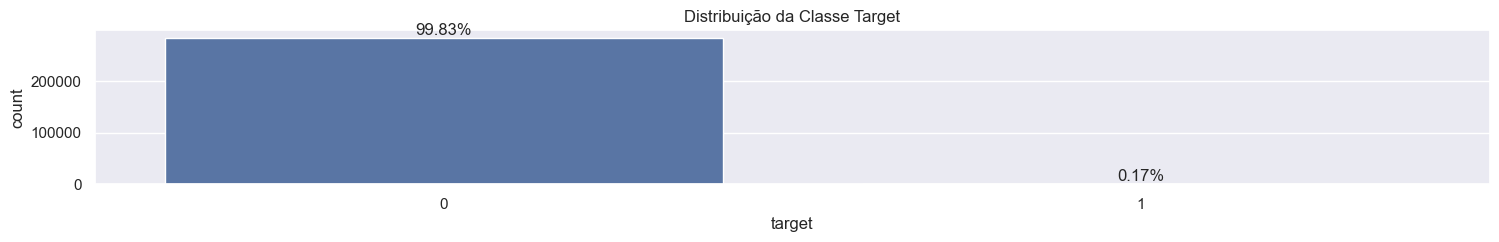

In [188]:
plt.figure(figsize = (18, 2))  # Ajuste o tamanho conforme necessário
ax = sns.countplot(x = 'target', data = df4)

proporcoes = df4['target'].value_counts(normalize = True)

# Adicionar as proporções em cada barra
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x_position = p.get_x() + width / 2  # posição horizontal do texto
    y_position = height  # posição vertical do texto
    
    # Coloca o texto com a proporção
    ax.text(x_position, y_position, f'{height / len(df4):.2%}', ha="center", va="bottom")

plt.title('Distribuição da Classe Target')
plt.show();

Temos uma classe altamente desbalanceada: 0 - Não houve fraude e 1 - Houve fraude. Observe que a barra correspondente ao não houve fraude é significativamente maior, enquanto a de houve fraude quase não aparece. Isso ocorre porque há muito mais transferências bancárias legítimas do que fraudulentas.

Se tentarmos construir um modelo preditivo com os dados no estado atual, ele terá dificuldades para prever fraudes, já que há pouquíssimos registros da classe Houve Fraude.

In [189]:
analise_normalidade(df4)

,Shapiro-Wilk,Lilliefors,Anderson-Darling
timestamp,Não segue uma distribuição normal,Não segue uma distribuição normal,Não segue uma distribuição normal
pais,Não segue uma distribuição normal,Não segue uma distribuição normal,Não segue uma distribuição normal
cidade,Não segue uma distribuição normal,Não segue uma distribuição normal,Não segue uma distribuição normal
bairro,Não segue uma distribuição normal,Não segue uma distribuição normal,Não segue uma distribuição normal
ip,Não segue uma distribuição normal,Não segue uma distribuição normal,Não segue uma distribuição normal
so,Não segue uma distribuição normal,Não segue uma distribuição normal,Não segue uma distribuição normal
valor,Não segue uma distribuição normal,Não segue uma distribuição normal,Não segue uma distribuição normal
antecedentes,Não segue uma distribuição normal,Não segue uma distribuição normal,Não segue uma distribuição normal
reclamacoes,Não segue uma distribuição normal,Não segue uma distribuição normal,Não segue uma distribuição normal
qtd_trans,Não segue uma distribuição normal,Não segue uma distribuição normal,Não segue uma distribuição normal


Possivelmente as variáveis não seguem uma distribuição normal, pode ser indicativo da necessidade de transformações nos dados para melhorar sua adequação aos modelos estatísticos, também é possivel observar que algumas variáveis possuem alguns outliers. Contudo também posteriormente serão feitos outros testes para validar esta distribuição.

Obs.: Aparentemente os dados já estão normalizados ou padronizados e com isso a interpretação direta das variáveis pode se tornar mais desafiadora, pois os valores não representam mais a escala original das variáveis, o que pode dificultar a análise exploratória de dados (EDA).

#### 4.1.3 Verificar se existem outliers

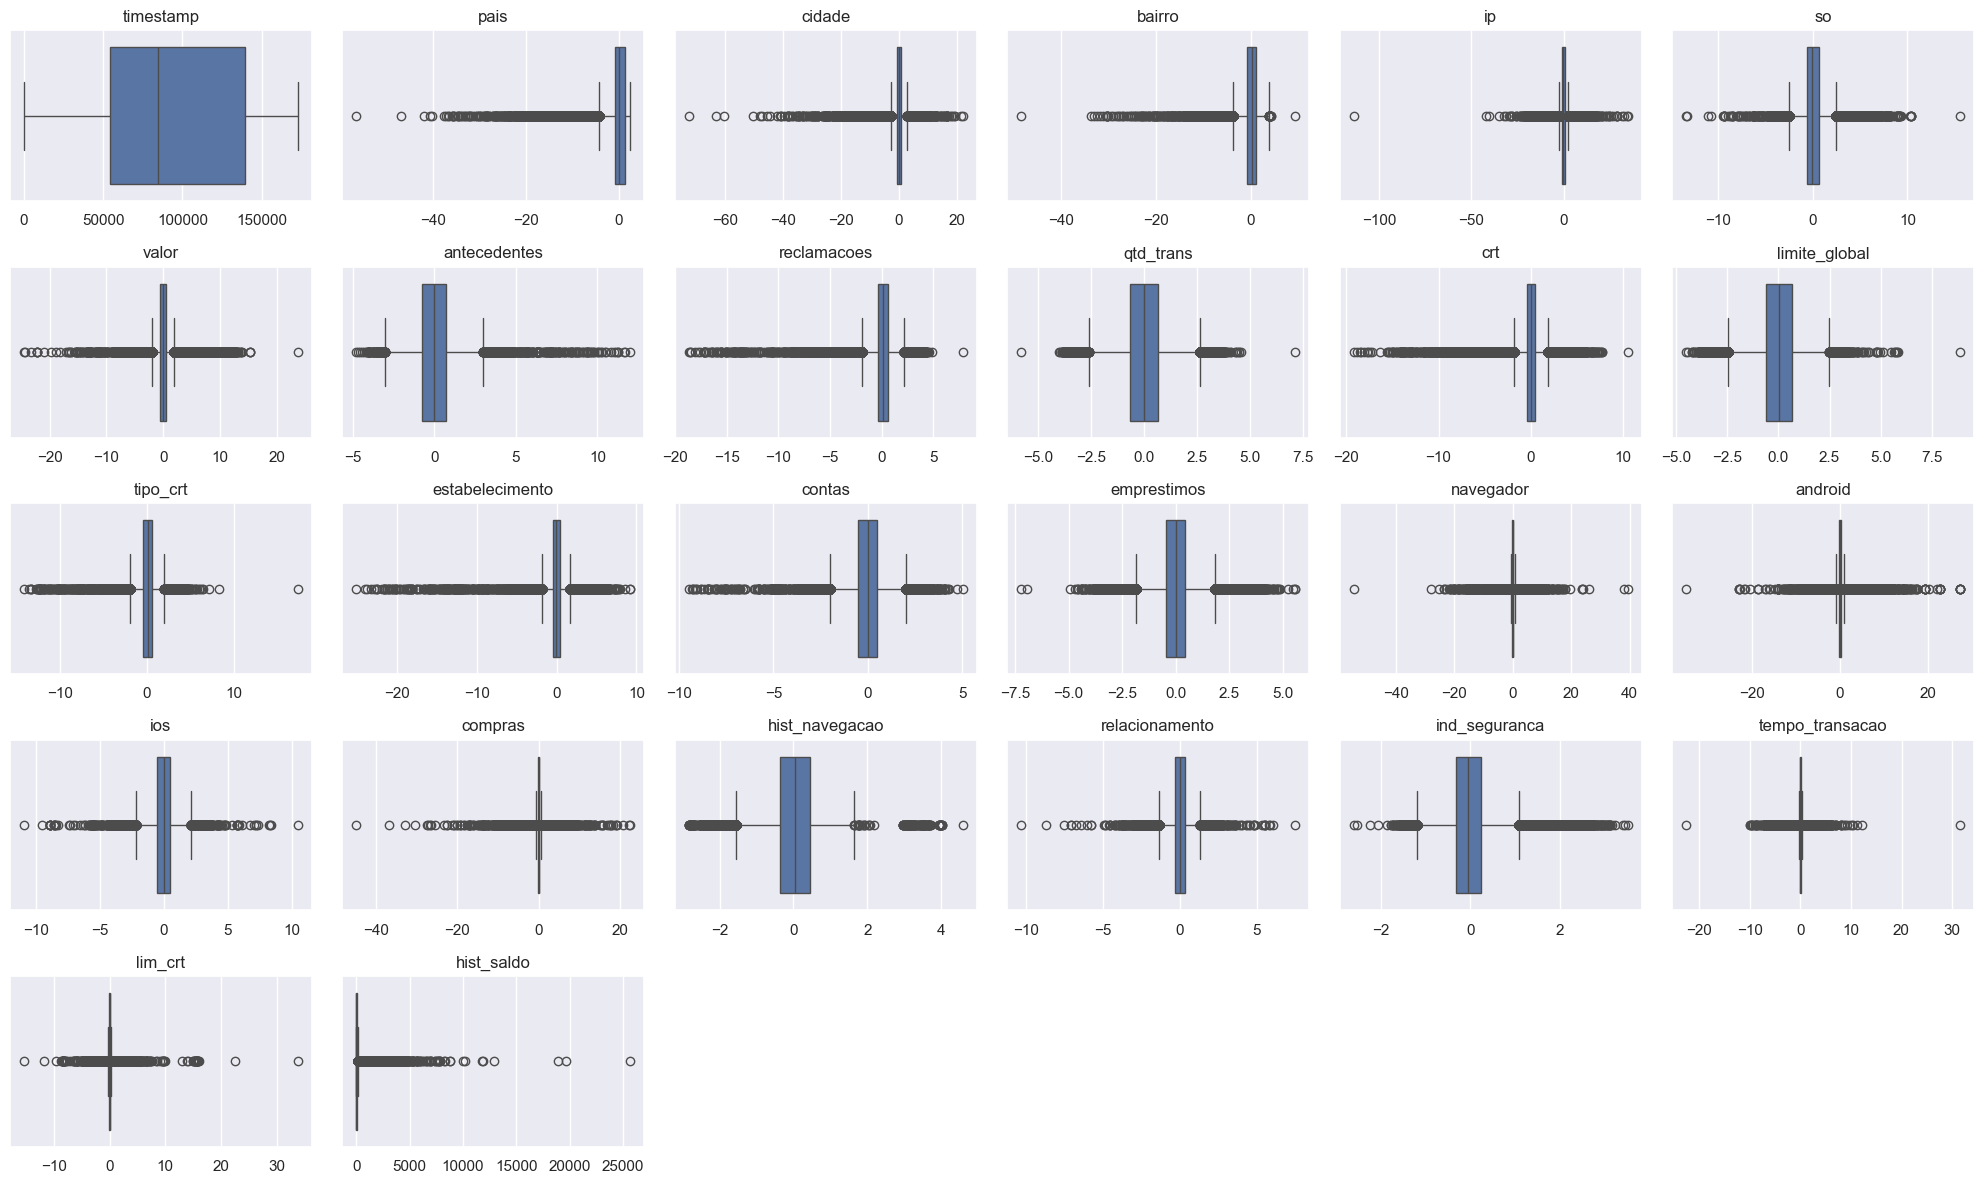

In [190]:
fig = plt.figure(figsize = (20, 12))
grid = GridSpec(5, 6, figure = fig)

colunas = ['timestamp', 'pais', 'cidade', 'bairro', 'ip', 'so', 'valor',
           'antecedentes', 'reclamacoes', 'qtd_trans', 'crt', 'limite_global',
           'tipo_crt', 'estabelecimento', 'contas', 'emprestimos', 'navegador',
           'android', 'ios', 'compras', 'hist_navegacao', 'relacionamento',
           'ind_seguranca', 'tempo_transacao', 'lim_crt', 'hist_saldo']

for i, coluna in enumerate(colunas):
    ax = plt.subplot(grid[i // 6, i % 6])
    sns.boxplot(x = df4[coluna], ax = ax)
    ax.set_title(coluna)
    ax.set_xlabel('')

plt.tight_layout()
plt.show();

Existem muitas variáveis com presença de outliers. Essa questão deverá ser analisada com mais atenção durante o treinamento do modelo.

### 4.2 Análise bivariada

1. Cidade
    - Existem cidades específicas com maior risco de fraude?

**Verdadeira** Cidade com valores entre 1 e 4, tem maior incidência de fraude

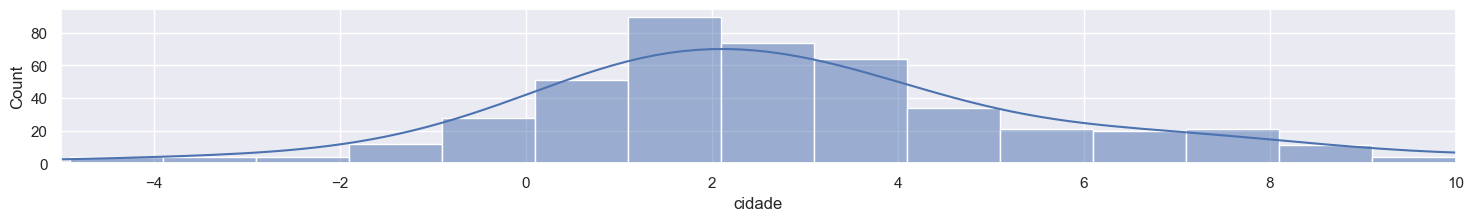

In [191]:
plt.figure(figsize = (18, 2))

aux = df4.loc[df4['target'] == 1, 'cidade']
sns.histplot(x = aux, kde = True, discrete = True)
plt.xlim(-5, 10)
plt.show();

2. Sistema Operacional (SO)
    - Existem sistemas operacionais associados a mais fraudes?

**Verdadeira** Sistema Operacional (SO) com valores entre -2.5 e 0, tem maior incidência de fraude

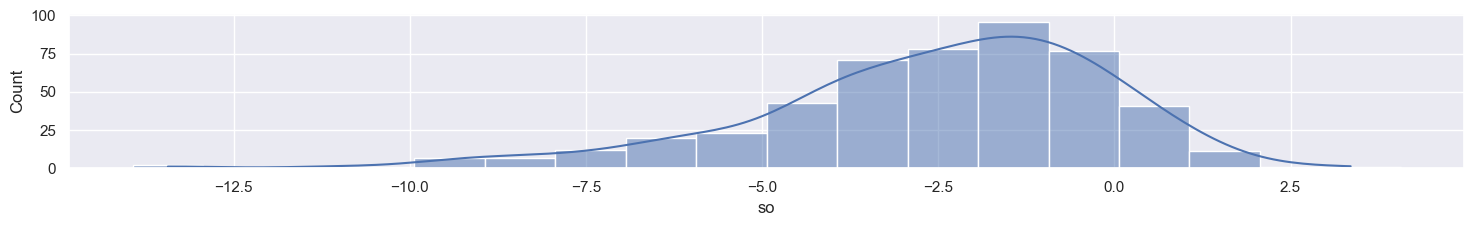

In [192]:
plt.figure(figsize = (18, 2))

aux = df4.loc[df4['target'] == 1, 'so']
sns.histplot(x = aux, kde = True, discrete = True)
plt.show();

3. Valor
    - Transações com valores elevados são mais suspeitas?

**Falsa** Valor com valores negativos tem maior incidência de fraude

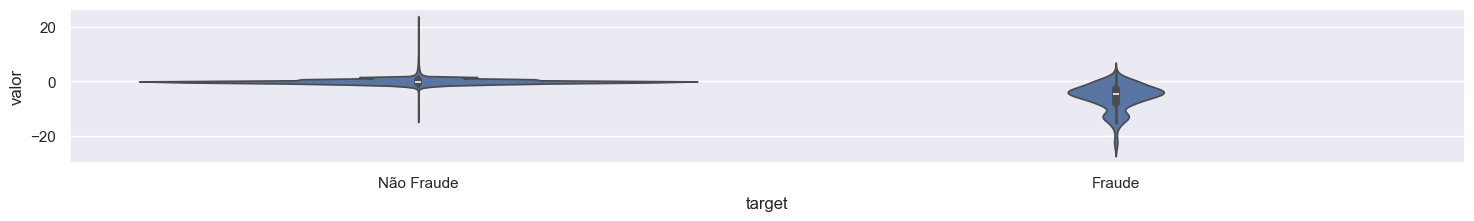

In [193]:
plt.figure(figsize = (18, 2))

sns.violinplot(x = 'target', y = 'valor', data = df4)
plt.xticks(ticks = [0, 1], labels = ['Não Fraude', 'Fraude'])
plt.show();

4. Antecedentes
    - Usuários com histórico de fraudes têm maior risco de fraude?

**Verdadeira** Antecedentes com valores entre 2 e 5, tem maior incidência de fraude

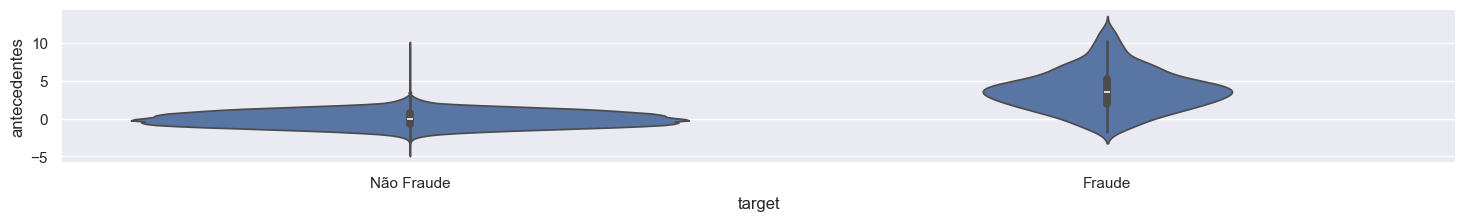

In [194]:
plt.figure(figsize = (18, 2))

sns.violinplot(x = 'target', y = 'antecedentes', data = df4)
plt.xticks(ticks = [0, 1], labels = ['Não Fraude', 'Fraude'])
plt.show();

5. Reclamações
    - Usuários com muitas reclamações estão mais propensos a cometer fraudes?

**Falsa** Reclamações com valores abaixo de -4 tem maior incidência de fraude

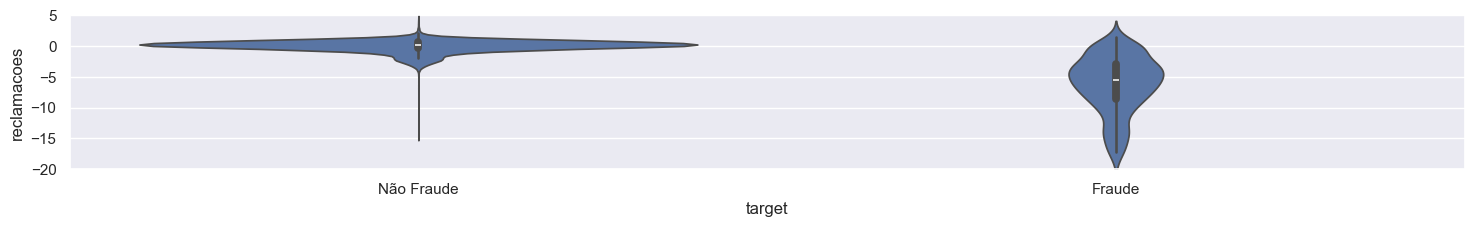

In [195]:
plt.figure(figsize = (18, 2))

sns.violinplot(x = 'target', y = 'reclamacoes', data = df4)
plt.xticks(ticks = [0, 1], labels = ['Não Fraude', 'Fraude'])
plt.ylim(-20, 5)
plt.show();

6. Cartão
    - Mudanças no cartão associado indicam risco de fraude?

**Verdadeira** Cartão com valores abaixo de -5 tem maior incidência de fraude

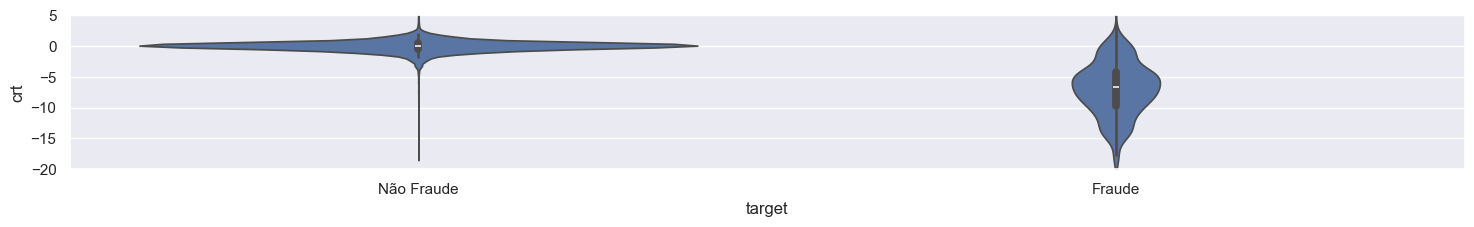

In [196]:
plt.figure(figsize = (18, 2))

sns.violinplot(x = 'target', y = 'crt', data = df4)
plt.xticks(ticks = [0, 1], labels = ['Não Fraude', 'Fraude'])
plt.ylim(-20, 5)
plt.show();

7. Tipo de Cartão
    - Há tipos de cartão com maior propensão a fraudes?

**Verdadeira** Tipo de Cartão com valores entre -4 e -1.5, tem maior incidência de fraude

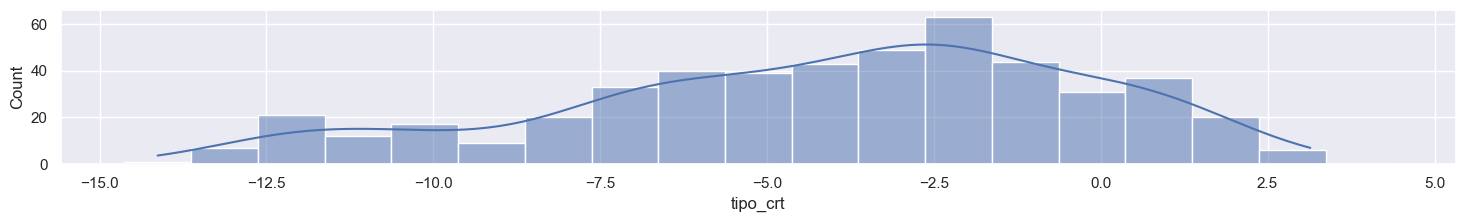

In [197]:
plt.figure(figsize = (18, 2))

aux = df4.loc[df4['target'] == 1, 'tipo_crt']
sns.histplot(x = aux, kde = True, discrete = True)
plt.show();

8. Estabelecimento
    - Estabelecimentos frequentes diminuem a probabilidade de fraude?

**Falsa** Estabelecimento com valores entre -7 e 2, tem maior incidência de fraude

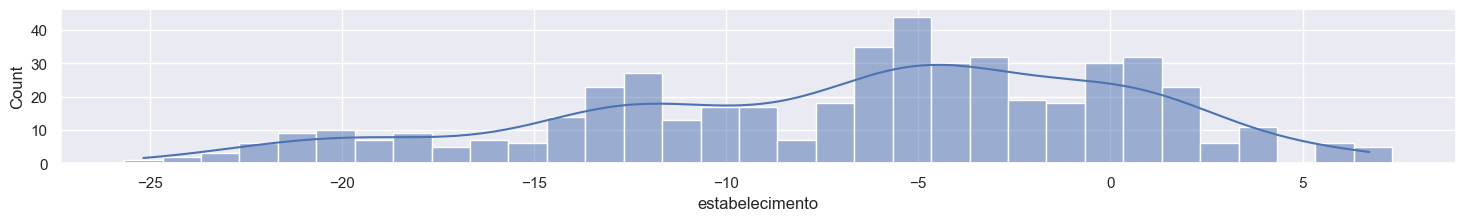

In [198]:
plt.figure(figsize = (18, 2))

aux = df4.loc[df4['target'] == 1, 'estabelecimento']
sns.histplot(x = aux, kde = True, discrete = True)
plt.show();

9. Android / IOS
    - Qual plataforma tem mais indicios de fraude?

**Verdadeira** A plataforma IOS tem maior incidência de fraude

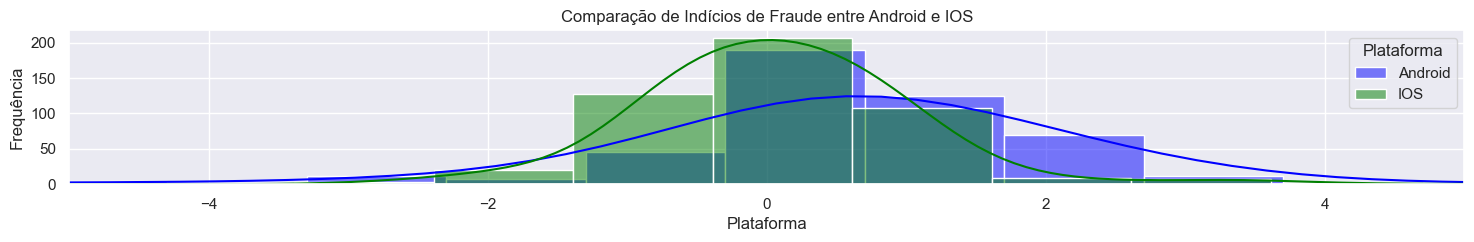

In [199]:
plt.figure(figsize = (18, 2))

android_data = df4.loc[df4['target'] == 1, 'android']
ios_data = df4.loc[df4['target'] == 1, 'ios']

sns.histplot(android_data, kde = True, label = 'Android', color = 'blue', discrete = True)
sns.histplot(ios_data, kde = True, label = 'IOS', color = 'green', discrete = True)

plt.xlim(-5, 5)
plt.title('Comparação de Indícios de Fraude entre Android e IOS')
plt.xlabel('Plataforma')
plt.ylabel('Frequência')
plt.legend(title = "Plataforma")

plt.show();

10. Índice de Segurança
    - Um baixo índice de segurança está associado a fraudes anteriores?

**Falsa** Índice de Segurança não é possivel afirmar que um baixo nível de segurança tem maior incidência de fraude

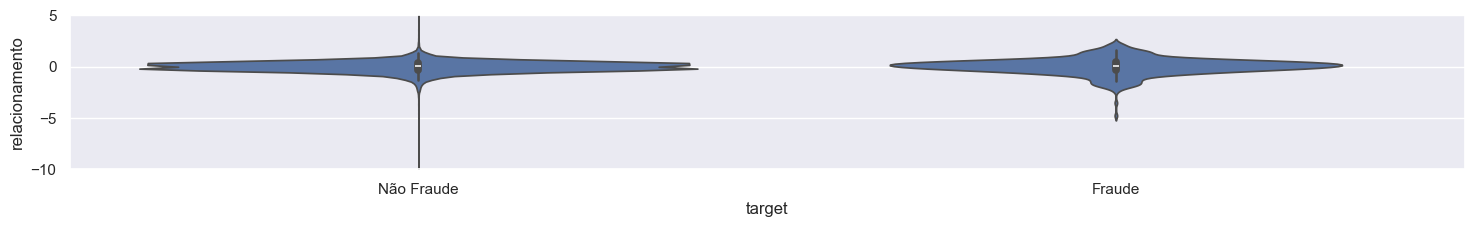

In [200]:
plt.figure(figsize = (18, 2))

sns.violinplot(x = 'target', y = 'relacionamento', data = df4)
plt.xticks(ticks = [0, 1], labels = ['Não Fraude', 'Fraude'])
plt.ylim(-10, 5)
plt.show();

11. Tempo de Transação
    - O tempo da transação afeta a probabilidade de fraude?

**Verdadeira** Tempo de Transação com valor superior a 0 tem maior incidência de fraude

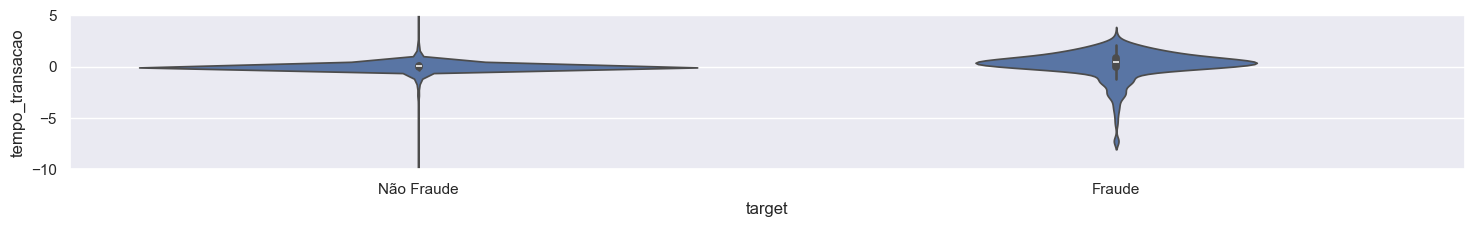

In [201]:
plt.figure(figsize = (18, 2))

sns.violinplot(x = 'target', y = 'tempo_transacao', data = df4)
plt.xticks(ticks = [0, 1], labels = ['Não Fraude', 'Fraude'])
plt.ylim(-10, 5)
plt.show();

12. Histórico de Saldo
    - Variações no histórico de saldo podem indicar atividade fraudulenta?

**Falsa** Histórico de Saldo não é possivel afirmar que uma variação no histórico de saldo tem maior incidência de fraude

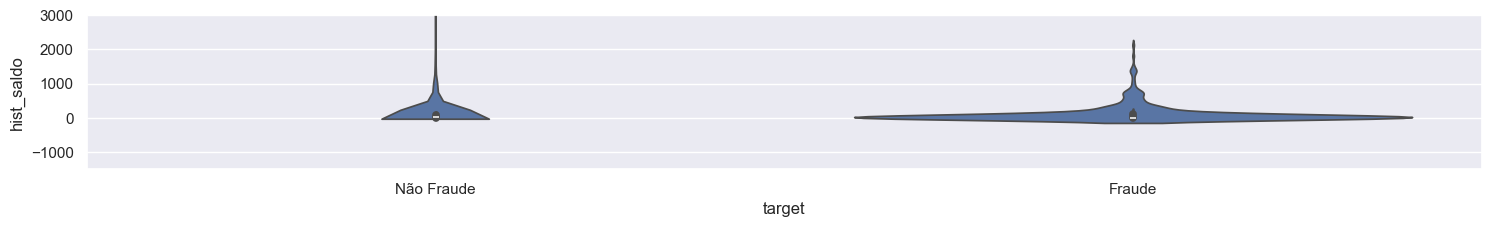

In [202]:
plt.figure(figsize = (18, 2))

sns.violinplot(x = 'target', y = 'hist_saldo', data = df4)
plt.xticks(ticks = [0, 1], labels = ['Não Fraude', 'Fraude'])
plt.ylim(-1500, 3000)
plt.show();

### 4.3 Análise multivariada

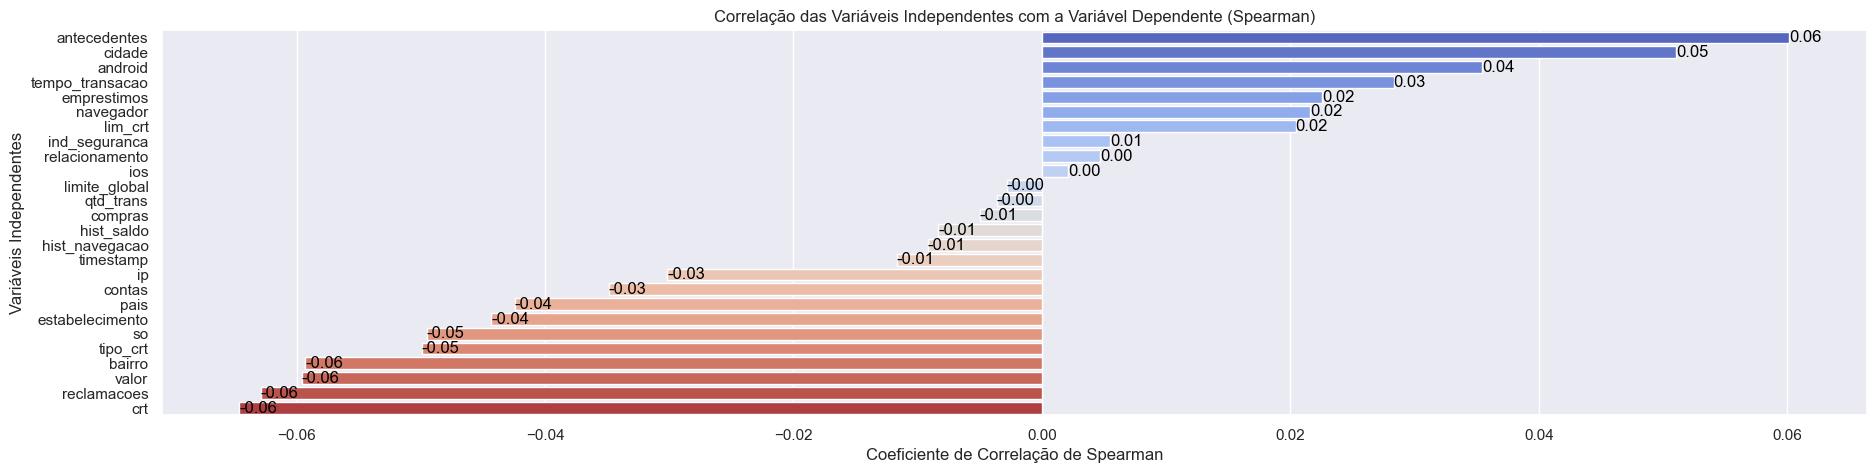

In [203]:
correlacao(df4, 'spearman', 'target')

É possível observar que as variáveis 'antecedentes' e 'cidade' apresentam uma correlação positiva. Isso significa que, quanto maior essa correlação, maior é a probabilidade de ocorrer uma operação fraudulenta. Por outro lado, as variáveis 'crt', 'reclamações', 'valor' e 'bairro' apresentam uma correlação negativa, indicando uma menor probabilidade de operações fraudulentas.

# 5. (Modelagem dos dados) Passo 5: Preparação dos dados
#### Neste tópico, os dados poderão ser transformados, ou seja, as variáveis categóricas poderão ser convertidas em números, as variáveis numéricas poderão ser reescalados, em outras palavras, colocadas em uma escala comum.

In [204]:
df5 = df4.copy()

### 5.1 Separar os dados em treino e teste

In [205]:
colunas_numericas = ['timestamp', 'pais', 'cidade', 'bairro', 'ip', 'so', 'valor',
                     'antecedentes', 'reclamacoes', 'qtd_trans', 'crt', 'limite_global',
                     'tipo_crt', 'estabelecimento', 'contas', 'emprestimos', 'navegador',
                     'android', 'ios', 'compras', 'hist_navegacao', 'relacionamento',
                     'ind_seguranca', 'tempo_transacao', 'lim_crt', 'hist_saldo']

colunas_categoricas = []

variavel_dependente = 'target'

variaveis_independentes = [col for col in colunas_numericas if col != variavel_dependente]

In [206]:
x = df5[variaveis_independentes]
y = df5[variavel_dependente].copy()

x_treino, x_teste, y_treino, y_teste = ms.train_test_split(x, y, test_size = 0.2, random_state = 42)

In [207]:
print('x_treino: {}'.format(x_treino.shape))
print('x_teste: {}'.format(x_teste.shape))
print('y_treino: {}'.format(y_treino.shape))
print('y_teste: {}'.format(y_teste.shape))

x_treino: (227845, 26)
x_teste: (56962, 26)
y_treino: (227845,)
y_teste: (56962,)


### <s>5.2 Balancear as classes</s>

In [208]:
## Aplicação do SMOTE
#smote = SMOTE(random_state = 42)
#x_treino_bal, y_treino_bal = smote.fit_resample(x_treino, y_treino)
#
## Verificando a distribuição de classes
#print("Distribuição de classes antes:", y_treino.value_counts())
#print("Distribuição de classes depois:", y_treino_bal.value_counts())

Mesmo diante do desbalanceamento das classes, optou-se por manter a distribuição original dos dados, uma vez que essa abordagem demonstrou resultar em métricas de desempenho superiores em comparação com o uso de técnicas de balanceamento de classes.

### <s>5.3 Aplicar PCA</s>

Suponha que você tenha um conjunto de dados com 10 variáveis, e após aplicar o PCA, você determina que as duas primeiras componentes principais (PC1 e PC2) explicam 90% da variação dos dados. Isso significa que você pode representar os dados com apenas 2 variáveis (PC1 e PC2) em vez de 10, o que pode simplificar a análise e reduzir a complexidade do modelo.

In [209]:
#pca = PCA()
#pca_components = pca.fit_transform(x_treino_bal)
#
#df_pca = pd.DataFrame(pca_components, columns = [f'PC{i+1}' for i in range(pca_components.shape[1])])
#df_pca.head()

In [210]:
#df_explicacao = pd.DataFrame({'variável_explicada': pca.explained_variance_ratio_,
#                              'variável_explicada_acumulada': pca.explained_variance_ratio_.cumsum()},
#                             index = [f'PC{i+1}' for i in range(pca.n_components_)])
#
## Definir a precisão para mostrar todos os números completos
#pd.set_option('display.float_format', '{:.15f}'.format)
#
#df_explicacao.head(3)

Conforme mostrado, a primeira componente principal (PC1) explica 99.9978909282563% da variância do problema. Ou seja, ela captura a maior parte das informações presentes nos dados. Isso significa que, ao reduzir a dimensionalidade para apenas a primeira componente principal, você ainda mantém quase toda a variação dos dados originais.

In [211]:
## Selecionando as colunas que serão usadas depois do PCA
#colunas_pca = ['PC1']
#
## Salvando o dataframe com as colunas do PCA
#x_treino_bal_pca = df_pca[colunas_pca]

In [212]:
## Aplicando a transformação PCA nos dados de teste com base no PCA ajustado no treino
#pca_components_teste = pca.transform(x_teste)  # Transforma os dados de teste com o PCA ajustado
#
## Convertendo os componentes do PCA de teste em um DataFrame
#df_pca_teste = pd.DataFrame(pca_components_teste, columns=[f'PC{i+1}' for i in range(pca_components_teste.shape[1])])
#
#x_teste_pca = df_pca_teste[colunas_pca]

### 5.3 Pipeline dos dados

REGRAS PARA ESCOLHA DO TIPO DE TRANSFORMAÇÃO:

1. **Distribuição normal** e não possui outliers -> <span style = "color:yellow">Padronização (StandardScaler)</span>
   - Este tipo de transformação é indicado para variáveis que seguem uma distribuição normal.
   - Verificar na análise univariada quais variáveis apresentam distribuição normal.
   - **Resultado:** média 0 e desvio padrão 1.

2. **Distribuição não normal** e não possui outliers -> <span style = "color:yellow">Normalização (MinMaxScaler)</span>
   - Indicada para variáveis com distribuição não normal.
   - Transforma os dados para um intervalo entre 0 e 1.
   - **Quando usar:** quando os dados precisam ser colocados em uma escala limitada.

3. **Distribuição normal ou não normal** e possui outliers -> <span style = "color:yellow">Normalização (RobustScaler)</span>
   - Utiliza os quartis para normalizar os dados, o que torna a transformação robusta a outliers.
   - **Quando usar:** útil quando há presença de outliers que impactam os dados, mantendo a mediana centralizada.

4. **Distribuição não normal** e com valoreses positivos -> <span style = "color:yellow">Transformação Logarítmica</span>
   - Aplica-se a variáveis com assimetria positiva, yellowuzindo a diferença entre valores altos e baixos.
   - **Quando usar:** indicada quando a relação entre variáveis é multiplicativa ou quando os valores possuem grandes diferenças de magnitude.
   - **Resultado:** distribuições com grande assimetria positiva se tornam mais simétricas.

5. **Distribuição não normal** e contém valores positivos -> <span style = "color:yellow">Transformação Box-Cox</span>
   - Usada para estabilizar a variância e transformar a distribuição em algo próximo ao normal.
   - **Quando usar:** aplicável em dados com distribuição não normal e que atendem ao critério de positividade.
   - **Resultado:** pode corrigir tanto assimetrias positivas quanto negativas, ajustando os dados para uma distribuição próxima da normal.

In [213]:
transformacao_numerica = Pipeline(steps = [('scaler', MinMaxScaler())]) # Aqui somente está sendo definido o que precisa ser feito
                                            # Nome da etapa
                                            # O objeto de transformação que será aplicado aos dados
                                            
#transformacao_categorica = OneHotEncoder(drop = 'if_binary', handle_unknown = 'ignore', sparse_output = False) 

#colunas_numericas = colunas_pca # Nomes das colunas numéricas

preprocessor = ColumnTransformer(transformers = [('num', transformacao_numerica, variaveis_independentes)])
                                                 # Um nome identificando a transformação
                                                 # Um objeto transformador ou um Pipeline
                                                 # As colunas às quais a transformação será aplicada

In [214]:
#dados_transformados = preprocessor.fit_transform(df_pca[colunas_pca])
#dados_transformados_df = pd.DataFrame(dados_transformados, columns = colunas_pca)
#dados_transformados_df.head(3)
#dados_transformados = preprocessor.fit_transform(x_treino_bal)
#dados_transformados_df = pd.DataFrame(dados_transformados, columns = variaveis_independentes)
#dados_transformados_df.head(3)
dados_transformados = preprocessor.fit_transform(x_treino[variaveis_independentes])
dados_transformados_df = pd.DataFrame(dados_transformados, columns = variaveis_independentes)
dados_transformados_df.head(3)

,timestamp,pais,cidade,bairro,ip,so,valor,antecedentes,reclamacoes,qtd_trans,crt,limite_global,tipo_crt,estabelecimento,contas,emprestimos,navegador,android,ios,compras,hist_navegacao,relacionamento,ind_seguranca,tempo_transacao,lim_crt,hist_saldo
0,0.829622,0.991508,0.763241,0.914254,0.762287,0.606194,0.616505,0.322452,0.767945,0.545538,0.637537,0.305946,0.459123,0.704083,0.698111,0.576433,0.578930,0.565319,0.555202,0.666224,0.344693,0.575381,0.390038,0.239485,0.312167,0.000389
1,0.678116,0.951482,0.760643,0.949870,0.764991,0.563425,0.632611,0.169620,0.676807,0.530451,0.605929,0.378502,0.444260,0.683756,0.798195,0.431123,0.575257,0.559005,0.529703,0.667118,0.246933,0.511856,0.484568,0.229472,0.310186,0.001787
2,0.865578,0.959526,0.775917,0.909563,0.772990,0.556187,0.601247,0.316323,0.701450,0.370287,0.624526,0.270506,0.470918,0.732419,0.689188,0.578837,0.580396,0.556407,0.469307,0.666672,0.402201,0.553688,0.444999,0.243369,0.314550,0.000467


In [215]:
pipeline_modelo = Pipeline(steps = [('preprocessor', preprocessor), 
                                    ('modelo', DummyClassifier(random_state = 42))])

In [216]:
pipeline_modelo
pipeline_modelo.named_steps
pipeline_modelo['modelo']

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['timestamp', 'pais',
                                                   'cidade', 'bairro', 'ip',
                                                   'so', 'valor',
                                                   'antecedentes',
                                                   'reclamacoes', 'qtd_trans',
                                                   'crt', 'limite_global',
                                                   'tipo_crt',
                                                   'estabelecimento', 'contas',
                                                   'emprestimos', 'navegador',
                                                   'android', 'ios', 'compras',
                                                   'hist_navegacao',
                                                   'relacionamento',
                                                   'ind_seguranca',
                                                   'tempo_transacao', 'lim_crt',
                                                   'hist_saldo'])])),
                ('modelo', DummyClassifier(random_state=42))])

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', MinMaxScaler())]),
                                  ['timestamp', 'pais', 'cidade', 'bairro', 'ip',
                                   'so', 'valor', 'antecedentes', 'reclamacoes',
                                   'qtd_trans', 'crt', 'limite_global',
                                   'tipo_crt', 'estabelecimento', 'contas',
                                   'emprestimos', 'navegador', 'android', 'ios',
                                   'compras', 'hist_navegacao', 'relacionamento',
                                   'ind_seguranca', 'tempo_transacao', 'lim_crt',
                                   'hist_saldo'])]),
 'modelo': DummyClassifier(random_state=42)}

DummyClassifier(random_state=42)

### 5.4 Treinar com vários modelos

In [218]:
modelos = [DummyClassifier(strategy = "most_frequent", random_state = 42),
           KNeighborsClassifier(n_neighbors = 3),
           LogisticRegression(max_iter = 100),
           RandomForestClassifier(n_estimators = 5, random_state = 42),
           GradientBoostingClassifier(n_estimators = 5, random_state = 42)]

pipeline_modelo = Pipeline(steps = [('preprocessor', preprocessor),
                                    ('modelo', DummyClassifier())])

# Validação Cruzada Estratificada
stratified_cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

grid_search_modelo = GridSearchCV(pipeline_modelo,
                                  param_grid = {'modelo': modelos},
                                  cv = stratified_cv, # Validação cruzada
                                  n_jobs = -1, # Usar todos os núcleos
                                  scoring = 'recall') # Métrica de avaliação: recall

# Ajustar o modelo nos dados de treinamento
#grid_search_modelo.fit(x_treino_bal, y_treino_bal)
grid_search_modelo.fit(x_treino[variaveis_independentes], y_treino)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['timestamp',
                                                                          'pais',
                                                                          'cidade',
                                                                          'bairro',
                                                                          'ip',
                                                                          'so',
                                                                          'valor',
                                                                          'antecedentes',
                                                                          'reclamacoes',
                                                                          'qtd_trans',
                                                                          'crt',
                                                                          'limite_global',
                                                                          'tipo_crt',
                                                                          'estabelecimento',
                                                                          'con...
                                                                          'tempo_transacao',
                                                                          'lim_crt',
                                                                          'hist_saldo'])])),
                                       ('modelo', DummyClassifier())]),
             n_jobs=-1,
             param_grid={'modelo': [DummyClassifier(random_state=42,
                                                    strategy='most_frequent'),
                                    KNeighborsClassifier(n_neighbors=3),
                                    LogisticRegression(),
                                    RandomForestClassifier(n_estimators=5,
                                                           random_state=42),
                                    GradientBoostingClassifier(n_estimators=5,
                                                               random_state=42)]},
             scoring='recall')

### 5.5 Modelo escolhido

In [219]:
grid_search_modelo.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['timestamp', 'pais',
                                                   'cidade', 'bairro', 'ip',
                                                   'so', 'valor',
                                                   'antecedentes',
                                                   'reclamacoes', 'qtd_trans',
                                                   'crt', 'limite_global',
                                                   'tipo_crt',
                                                   'estabelecimento', 'contas',
                                                   'emprestimos', 'navegador',
                                                   'android', 'ios', 'compras',
                                                   'hist_navegacao',
                                                   'relacionamento',
                                                   'ind_seguranca',
                                                   'tempo_transacao', 'lim_crt',
                                                   'hist_saldo'])])),
                ('modelo',
                 RandomForestClassifier(n_estimators=5, random_state=42))])

In [220]:
df_resultado = pd.DataFrame(grid_search_modelo.cv_results_).set_index('rank_test_score').sort_index()
df_resultado.loc[:, ~df_resultado.columns.str.contains('split|time')]

,param_modelo,params,mean_test_score,std_test_score
rank_test_score,,,,
1,"RandomForestClassifier(n_estimators=5, random_...",{'modelo': RandomForestClassifier(n_estimators...,0.761506,0.028690
2,KNeighborsClassifier(n_neighbors=3),{'modelo': KNeighborsClassifier(n_neighbors=3)},0.751347,0.024087
3,"GradientBoostingClassifier(n_estimators=5, ran...",{'modelo': GradientBoostingClassifier(n_estima...,0.720902,0.030267
4,LogisticRegression(),{'modelo': LogisticRegression()},0.487634,0.078709
5,"DummyClassifier(random_state=42, strategy='mos...","{'modelo': DummyClassifier(random_state=42, st...",0.000000,0.000000


Em problemas de fraude, o <span style="color:yellow">recall</span> geralmente é mais importante que a precision, pois:    
- **Custo de falsos negativos (FN)**: Deixar de detectar uma fraude (falso negativo) pode resultar em grandes perdas financeiras e danos à reputação.
- **Custo de falsos positivos (FP)**: Classificar uma transação legítima como fraude (falso positivo) pode ser inconveniente, mas geralmente é menos crítico do que deixar uma fraude passar.

Portanto, o foco deve ser **maximizar o recall**, ou seja, garantir que o maior número possível de fraudes seja detectado.

O modelo escolhido foi `RandomForestClassifier`, dado seu resultado de recall de **0.761506**.

### 5.6 Treinar o modelo escolhido com os hiperparâmetros

In [221]:
pipeline_modelo = Pipeline(steps = [('preprocessor', preprocessor),
                                    ('modelo', RandomForestClassifier(random_state = 42))])
                                    

params = {'modelo__n_estimators': [5, 50],
          'modelo__max_depth': [1, 3],
          'modelo__min_samples_split': [2, 12]}

# Validação Cruzada Estratificada
stratified_cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

grid_search_modelo = GridSearchCV(pipeline_modelo,
                                  param_grid = params,
                                  cv = stratified_cv, # Validação cruzada
                                  n_jobs = -1, # Usar todos os núcleos
                                  scoring = 'recall') # Métrica de avaliação: recall
#grid_search_modelo.fit(x_treino_bal, y_treino_bal)
grid_search_modelo.fit(x_treino[variaveis_independentes], y_treino)
'''
pipeline_modelo = Pipeline(steps = [('preprocessor', preprocessor),
                                    ('modelo', RandomForestClassifier(random_state = 42))])

params = {'modelo__n_estimators': [5, 50],
          'modelo__max_depth': [1, 3],
          'modelo__min_samples_split': [2, 12]}

grid_search_modelo = GridSearchCV(pipeline_modelo,
                               param_grid = params,
                               cv = 5, # Validação cruzada
                               n_jobs = -1, # Usar todos os núcleos
                               scoring = 'precision') # Métrica de avaliação: precision
                               
grid_search_modelo.fit(x_treino_bal, y_treino_bal)
'''

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['timestamp',
                                                                          'pais',
                                                                          'cidade',
                                                                          'bairro',
                                                                          'ip',
                                                                          'so',
                                                                          'valor',
                                                                          'antecedentes',
                                                                          'reclamacoes',
                                                                          'qtd_trans',
                                                                          'crt',
                                                                          'limite_global',
                                                                          'tipo_crt',
                                                                          'estabelecimento',
                                                                          'contas',
                                                                          'emprestimos',
                                                                          'navegador',
                                                                          'android',
                                                                          'ios',
                                                                          'compras',
                                                                          'hist_navegacao',
                                                                          'relacionamento',
                                                                          'ind_seguranca',
                                                                          'tempo_transacao',
                                                                          'lim_crt',
                                                                          'hist_saldo'])])),
                                       ('modelo',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'modelo__max_depth': [1, 3],
                         'modelo__min_samples_split': [2, 12],
                         'modelo__n_estimators': [5, 50]},
             scoring='recall')

"\npipeline_modelo = Pipeline(steps = [('preprocessor', preprocessor),\n                                    ('modelo', RandomForestClassifier(random_state = 42))])\n\nparams = {'modelo__n_estimators': [5, 50],\n          'modelo__max_depth': [1, 3],\n          'modelo__min_samples_split': [2, 12]}\n\ngrid_search_modelo = GridSearchCV(pipeline_modelo,\n                               param_grid = params,\n                               cv = 5, # Validação cruzada\n                               n_jobs = -1, # Usar todos os núcleos\n                               scoring = 'precision') # Métrica de avaliação: precision\n                               \ngrid_search_modelo.fit(x_treino_bal, y_treino_bal)\n"

In [222]:
df_resultado = pd.DataFrame(grid_search_modelo.cv_results_).set_index('rank_test_score').sort_index()
df_resultado.loc[:, ~df_resultado.columns.str.contains('split|time')]

,param_modelo__max_depth,param_modelo__n_estimators,params,mean_test_score,std_test_score
rank_test_score,,,,,
1,3,5,"{'modelo__max_depth': 3, 'modelo__min_samples_...",0.662707,0.056403
2,3,5,"{'modelo__max_depth': 3, 'modelo__min_samples_...",0.660143,0.051588
3,3,50,"{'modelo__max_depth': 3, 'modelo__min_samples_...",0.624602,0.055747
4,3,50,"{'modelo__max_depth': 3, 'modelo__min_samples_...",0.619507,0.054280
5,1,5,"{'modelo__max_depth': 1, 'modelo__min_samples_...",0.439241,0.079616
5,1,5,"{'modelo__max_depth': 1, 'modelo__min_samples_...",0.439241,0.079616
7,1,50,"{'modelo__max_depth': 1, 'modelo__min_samples_...",0.396105,0.067790
7,1,50,"{'modelo__max_depth': 1, 'modelo__min_samples_...",0.396105,0.067790


In [223]:
pipeline_modelo = grid_search_modelo.best_estimator_
y_pred = pipeline_modelo.predict(x_teste)
metricas(y_teste, y_pred)


Matriz de Confusão:
          0 (Predito)  1 (Predito)
0 (Real)        56853           11
1 (Real)           35           63

Accuracy: 1.0
Recall: 0.64
Precision: 0.85
F1: 0.73
ROC_AUC: 0.82


TIPOS DE MÉTRICAS

1. **Accuracy**: Mede a porcentagem de predições corretas sobre o total. É <span style="color:yellow">útil para avaliar modelos com classes balanceadas</span>, mas pode ser enganoso em casos de desbalanceamento.

2. **Recall** (Sensibilidade): Avalia a proporção de positivos corretamente identificados. É ideal quando <span style="color:yellow">minimizar falsos negativos</span> é mais importante, como em diagnósticos médicos.

3. **Precision** (Precisão): Mede a proporção de predições positivas que realmente são positivas. É útil quando <span style="color:yellow">minimizar falsos positivos</span> é crucial, como em sistemas de detecção de fraude.

4. **F1-Score**: É a média harmônica entre Precision e Recall. Recomendado para cenários com <span style="color:yellow">desbalanceamento de classes</span>, pois combina ambas as métricas em uma única medida.

5. **ROC_AUC** (Área sob a curva ROC): Indica a capacidade do modelo em <span style="color:yellow">diferenciar entre classes</span>. Valores próximos de 1 indicam um bom desempenho; valores próximos de 0,5 indicam um modelo aleatório.

6. **Matriz de Confusão**: Apresenta o número de verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos. É <span style="color:yellow">essencial para entender a performance do modelo em detalhes</span>.

# 6. (Modelagem dos dados) Passo 6: Seleção das variáveis
#### Neste passo o principal objetivo é selecionar as variáveis mais relevantes e descartar as menos importantes, para que estas sejam submetidas aos algoritmos de machine learning. Esta seleção é feita através de diversas técnicas, objetivando reduzir a dimensionalidade dos dados sem perder em performance ao resultado final.

In [224]:
df6 = df5.copy()

### 6.1 Selecionar as variáveis mais relevantes do pipeline

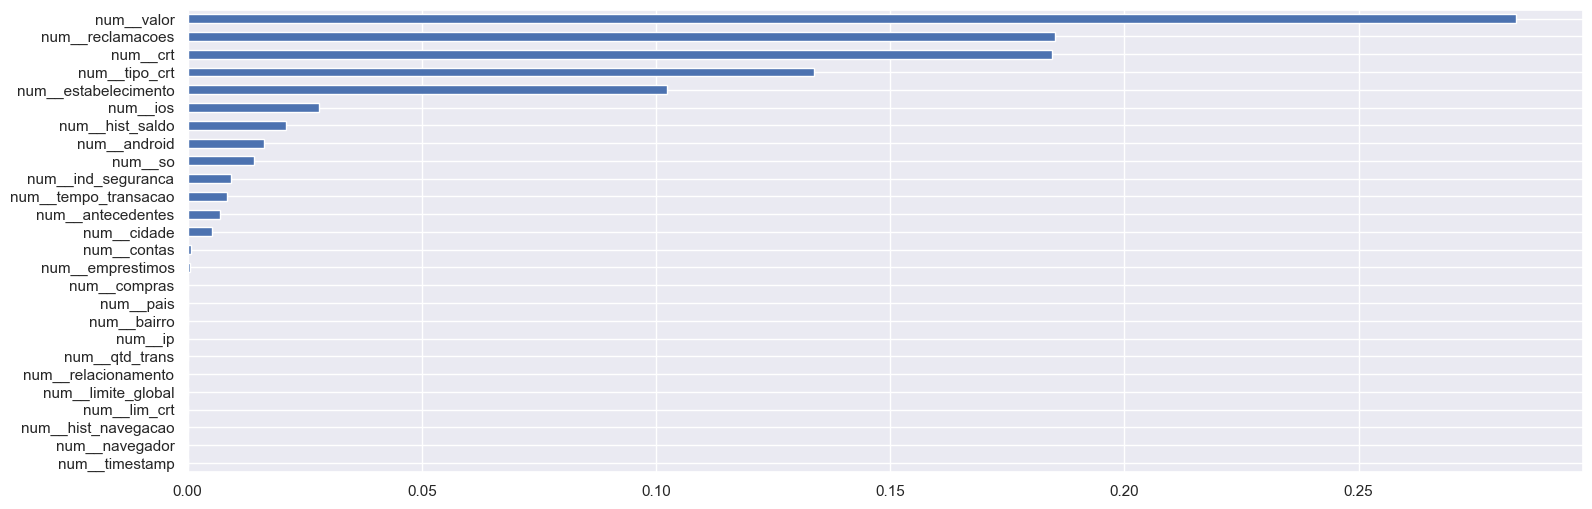

In [225]:
plt.figure(figsize = (18, 6)) # Largura = 18, Altura = 6

importances = pd.Series(data = pipeline_modelo.named_steps['modelo'].feature_importances_,
                        index = pipeline_modelo.named_steps['preprocessor'].get_feature_names_out())

importances.sort_values().plot.barh();

# 7. (Algoritmos de Ml) Passo 7: Treinar o modelo com as variáveis mais relevantes
#### Com a definição do melhor modelo de machine learning e as variável mais relevantes, busca-se otimizar ainda mais a performance do modelo com alguns ajustes finos em seus hiperparâmetros.

In [226]:
df7 = df6.copy()

### 7.1 Retreinar o modelo escolhido com os melhores hiperparâmetros e as melhores variáveis

In [227]:
colunas_numericas = ['cidade', 'so', 'valor', 'antecedentes', 'reclamacoes',
                     'crt', 'tipo_crt', 'estabelecimento', 'android', 'ios', 
                     'ind_seguranca', 'tempo_transacao', 'hist_saldo']

colunas_categoricas = []

variavel_dependente = 'target'

variaveis_independentes = [col for col in colunas_numericas if col != variavel_dependente]

In [228]:
transformacao_numerica = Pipeline(steps = [('scaler', MinMaxScaler())]) # Aqui somente está sendo definido o que precisa ser feito
                                            # Nome da etapa
                                            # O objeto de transformação que será aplicado aos dados
                                            
#transformacao_categorica = OneHotEncoder(drop = 'if_binary', handle_unknown = 'ignore', sparse_output = False) 

#colunas_numericas = colunas_pca # Nomes das colunas numéricas

preprocessor = ColumnTransformer(transformers = [('num', transformacao_numerica, variaveis_independentes)])
                                                 # Um nome identificando a transformação
                                                 # Um objeto transformador ou um Pipeline
                                                 # As colunas às quais a transformação será aplicada

In [229]:
dados_transformados = preprocessor.fit_transform(x_treino[variaveis_independentes])
dados_transformados_df = pd.DataFrame(dados_transformados, columns = variaveis_independentes)
dados_transformados_df.head(3)

,cidade,so,valor,antecedentes,reclamacoes,crt,tipo_crt,estabelecimento,android,ios,ind_seguranca,tempo_transacao,hist_saldo
0,0.763241,0.606194,0.616505,0.322452,0.767945,0.637537,0.459123,0.704083,0.565319,0.555202,0.390038,0.239485,0.000389
1,0.760643,0.563425,0.632611,0.169620,0.676807,0.605929,0.444260,0.683756,0.559005,0.529703,0.484568,0.229472,0.001787
2,0.775917,0.556187,0.601247,0.316323,0.701450,0.624526,0.470918,0.732419,0.556407,0.469307,0.444999,0.243369,0.000467


In [230]:
pipeline_modelo = Pipeline(steps = [('preprocessor', preprocessor),
                                    ('modelo', RandomForestClassifier(random_state = 42))])

params = {'modelo__n_estimators': [5, 50],
          'modelo__max_depth': [1, 3],
          'modelo__min_samples_split': [2, 12]}

# Validação Cruzada Estratificada
stratified_cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

grid_search_modelo = GridSearchCV(pipeline_modelo,
                                  param_grid = params,
                                  cv = stratified_cv, # Validação cruzada
                                  n_jobs = -1, # Usar todos os núcleos
                                  scoring = 'recall') # Métrica de avaliação: recall

grid_search_modelo.fit(x_treino[variaveis_independentes], y_treino)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['cidade',
                                                                          'so',
                                                                          'valor',
                                                                          'antecedentes',
                                                                          'reclamacoes',
                                                                          'crt',
                                                                          'tipo_crt',
                                                                          'estabelecimento',
                                                                          'android',
                                                                          'ios',
                                                                          'ind_seguranca',
                                                                          'tempo_transacao',
                                                                          'hist_saldo'])])),
                                       ('modelo',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'modelo__max_depth': [1, 3],
                         'modelo__min_samples_split': [2, 12],
                         'modelo__n_estimators': [5, 50]},
             scoring='recall')

### 7.2 Performance final do modelo

In [231]:
pipeline_modelo = grid_search_modelo.best_estimator_
y_pred = pipeline_modelo.predict(x_teste[variaveis_independentes])
metricas(y_teste, y_pred)


Matriz de Confusão:
          0 (Predito)  1 (Predito)
0 (Real)        56854           10
1 (Real)           35           63

Accuracy: 1.0
Recall: 0.64
Precision: 0.86
F1: 0.74
ROC_AUC: 0.82


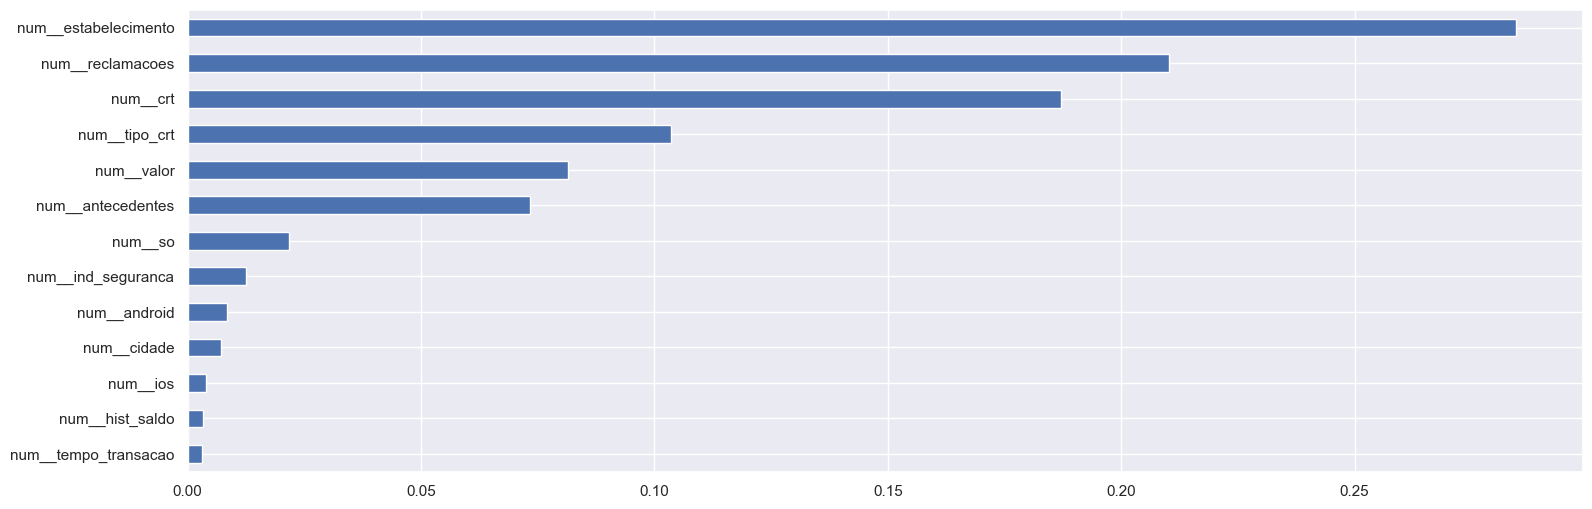

In [232]:
plt.figure(figsize = (18, 6)) # Largura = 18, Altura = 6

importances = pd.Series(data = pipeline_modelo.named_steps['modelo'].feature_importances_,
                        index = pipeline_modelo.named_steps['preprocessor'].get_feature_names_out())

importances.sort_values().plot.barh();

### 7.3 Ajustar o Threshold

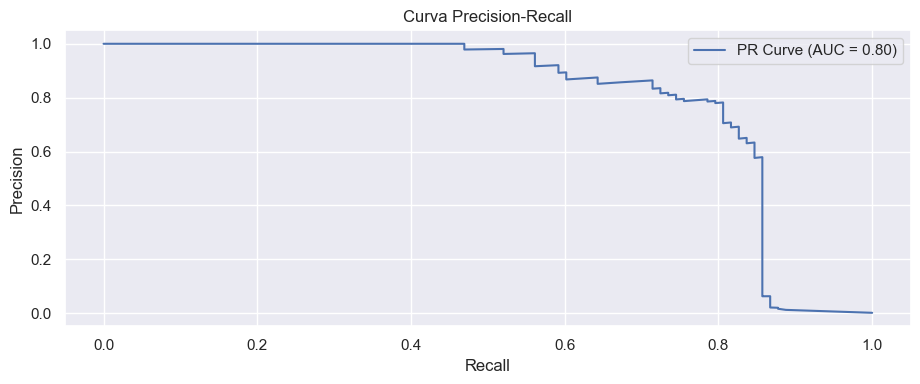

In [237]:
# Probabilidades previstas da classe positiva
y_proba = pipeline_modelo.predict_proba(x_teste)[:, 1]

# Curva Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_teste, y_proba)
pr_auc = auc(recall, precision)

# Plotando as curvas
plt.figure(figsize = (18, 4))

# Curva Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label = f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()

plt.tight_layout()
plt.show();

In [234]:
# Calcula precision, recall e thresholds
precision, recall, thresholds = precision_recall_curve(y_teste, y_proba)

# Encontra o threshold que garante recall >= 0.8
# Ignora o último ponto da curva (recall = 0, precision = 1)
threshold_ideal = thresholds[recall[:-1] >= 0.8][-1]  # Pega o maior threshold que atende à condição
print(f"Threshold ideal: {threshold_ideal}")

# Aplica o threshold ideal
y_pred_ideal = (y_proba > threshold_ideal).astype(int)

# Avalia o desempenho
metricas(y_teste, y_pred_ideal)

Threshold ideal: 0.13412403317172145

Matriz de Confusão:
          0 (Predito)  1 (Predito)
0 (Real)        56842           22
1 (Real)           20           78

Accuracy: 1.0
Recall: 0.8
Precision: 0.78
F1: 0.79
ROC_AUC: 0.9


### Resultado

Falsos Positivos (FP): 22 — transações legítimas classificadas como fraude.

Falsos Negativos (FN): 20 — transações fraudulentas não detectadas.

Verdadeiros Positivos (TP): 78 — transações fraudulentas corretamente identificadas.

Verdadeiros Negativos (TN): 56842 — transações legítimas corretamente identificadas.

- Accuracy (Acurácia): 1.0 — O modelo tem uma taxa de acerto de 100% nas previsões. Embora isso seja incomum em um problema de fraude real, essa métrica pode ser enganosa se as classes estiverem desbalanceadas.
- Recall (Sensibilidade): 0.8 — O modelo identifica 80% das fraudes corretamente.
- Precision (Precisão): 0.78 — O modelo classifica corretamente 78% das transações identificadas como fraude.
- F1 Score: 0.79 — A média harmônica entre precisão e recall, indicando um bom equilíbrio entre esses dois aspectos.
- ROC AUC: 0.9 — O modelo tem 90% de chance de classificar corretamente entre transações fraudulentas e legítimas, independentemente do limiar de decisão.

# 8. (Avaliação do algoritmo) Passo 8: Performance do negócio ROI
#### Nesta etapa, o termo "performance do negócio" refere-se ao impacto que os modelos e análises têm nos resultados e metas de uma organização, pois busca garantir que as soluções propostas realmente tragam benefícios tangíveis para a empresa.

### Custo Total e o ROI

***Passos para calcular:***
    - Obtenção dos valores da matriz de confusão:

Melhor modelo: Falsos Positivos (FP), Falsos Negativos (FN), Verdadeiros Positivos (TP), Verdadeiros Negativos (TN).

Penúltimo pior modelo: Falsos Positivos (FP), Falsos Negativos (FN), Verdadeiros Positivos (TP), Verdadeiros Negativos (TN).

***Definição dos custos:***

- Custo por investigação de falsos positivos.
- Custo de oportunidade por falsos negativos.
- Valor recuperado por fraude identificada.
    
***Cálculos:***

- Cálculo do Custo Total (soma de custos com falsos positivos e falsos negativos).
- Cálculo do Valor Recuperado por Fraude Identificada (multiplicação do número de fraudes identificadas corretamente pelo valor recuperado por fraude).
- Cálculo do ROI (retorno sobre o investimento).

In [249]:
# Definindo os dados dos dois modelos
# Melhor modelo
fp_model1 = 22 # Falsos Positivos
fn_model1 = 20 # Falsos Negativos
tp_model1 = 78 # Verdadeiros Positivos
tn_model1 = 56842 # Verdadeiros Negativos

# Penúltimo pior modelo
fp_model2 = 8  # Falsos Positivos
fn_model2 = 56 # Falsos Negativos
tp_model2 = 42 # Verdadeiros Positivos
tn_model2 = 56856 # Verdadeiros Negativos

# Definindo os custos
custo_por_investigacao_fp = 100 # Custo por investigação de Falsos Positivos (em unidades monetárias)
valor_recuperado_por_fraude = 500 # Valor recuperado por fraude identificada (em unidades monetárias)
custo_oportunidade_fn = 500 # Custo de oportunidade por Falsos Negativos (em unidades monetárias)

# Função para calcular Custo Total e ROI
def calcular_custo_roi(fp, fn, tp, tn, custo_fp, valor_fraude, custo_fn):
   # Calcular o Custo Total (FP + FN)
    custo_fp_total = fp * custo_fp
    custo_fn_total = fn * custo_fn
    custo_total = custo_fp_total + custo_fn_total
    
   # Calcular o Valor de Fraudes Identificadas
    valor_fraudes_identificadas = tp * valor_fraude
    
   # Calcular o ROI
    roi = (valor_fraudes_identificadas - custo_total) / custo_total
    
    return custo_fp_total, custo_fn_total, custo_total, valor_fraudes_identificadas, roi

# Calcular para o Modelo 1
custo_fp_total_model1, custo_fn_total_model1, custo_total_model1, valor_fraudes_model1, roi_model1 = calcular_custo_roi(
    fp_model1, fn_model1, tp_model1, tn_model1, custo_por_investigacao_fp, valor_recuperado_por_fraude, custo_oportunidade_fn)

# Calcular para o Modelo 2
custo_fp_total_model2, custo_fn_total_model2, custo_total_model2, valor_fraudes_model2, roi_model2 = calcular_custo_roi(
    fp_model2, fn_model2, tp_model2, tn_model2, custo_por_investigacao_fp, valor_recuperado_por_fraude, custo_oportunidade_fn)

# Exibir os resultados
print("Melhor Modelo:")
print(f"Custo de Falsos Positivos: {custo_fp_total_model1} unidades monetárias")
print(f"Custo de Falsos Negativos: {custo_fn_total_model1} unidades monetárias")
print(f"Custo Total: {custo_total_model1} unidades monetárias")
print(f"Valor das Fraudes Identificadas: {valor_fraudes_model1} unidades monetárias")
print(f"ROI: {roi_model1:.2f} (100% = retorno sobre o investimento)\n")

print("Penúltimo pior modelo:")
print(f"Custo de Falsos Positivos: {custo_fp_total_model2} unidades monetárias")
print(f"Custo de Falsos Negativos: {custo_fn_total_model2} unidades monetárias")
print(f"Custo Total: {custo_total_model2} unidades monetárias")
print(f"Valor das Fraudes Identificadas: {valor_fraudes_model2} unidades monetárias")
print(f"ROI: {roi_model2:.2f} (100% = retorno sobre o investimento)")

# Determinar o modelo mais vantajoso financeiramente
if roi_model1 > roi_model2:
    print("\nO melhor modelo é mais vantajoso financeiramente.")
else:
    print("\nO penúltimo pior modelo é mais vantajoso financeiramente.")

Melhor Modelo:
Custo de Falsos Positivos: 2200 unidades monetárias
Custo de Falsos Negativos: 10000 unidades monetárias
Custo Total: 12200 unidades monetárias
Valor das Fraudes Identificadas: 39000 unidades monetárias
ROI: 2.20 (100% = retorno sobre o investimento)

Penúltimo pior modelo:
Custo de Falsos Positivos: 800 unidades monetárias
Custo de Falsos Negativos: 28000 unidades monetárias
Custo Total: 28800 unidades monetárias
Valor das Fraudes Identificadas: 21000 unidades monetárias
ROI: -0.27 (100% = retorno sobre o investimento)

O melhor modelo é mais vantajoso financeiramente.
